In [2]:
!pip install catboost

     |████████████████████████████████| 10.7MB 12.7MB/s eta 0:00:01


In [3]:
# for preprocessing
import pandas as pd

# for math operations
import numpy as np

# for machine learning
from catboost import CatBoostRegressor, Pool

# for data scaling
from sklearn.preprocessing import StandardScaler

# for hyper  parameter optimization
from sklearn.model_selection import GridSearchCV

#support vector machine model
from sklearn.svm import NuSVR,NuSVC 

# kernal ridge model
from sklearn.kernel_ridge import KernelRidge

#Data visualization
import matplotlib.pyplot as plt

In [10]:
def extract_data(file_name, file_path):
    !kaggle competitions download LANL Earthquake\ prediction -f $file_name -p $file_path --force

In [11]:
# file name
import os
train_file_name= 'train.csv'
test_file_name= 'test.csv'

#file path
raw_data_path= os.path.join(os.path.pardir,'data', 'raw')
extract_data(train_file_name, raw_data_path)
extract_data(test_file_name, raw_data_path)

/bin/sh: kaggle: command not found
/bin/sh: kaggle: command not found


In [12]:
pwd

'/Users/anshulsharma/NEW PROJECTS  10th FEB 2020'

In [40]:
train= pd.read_csv('train.csv',nrows=60000000)

In [41]:
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [42]:
train.describe()

,acoustic_data,time_to_failure
count,6.000000e+07,6.000000e+07
mean,4.518558e+00,6.472908e+00
std,1.192783e+01,4.313729e+00
min,-4.621000e+03,6.954822e-04
25%,2.000000e+00,2.427696e+00
50%,5.000000e+00,6.323996e+00
75%,7.000000e+00,1.022030e+01
max,3.914000e+03,1.418060e+01


# data visualization

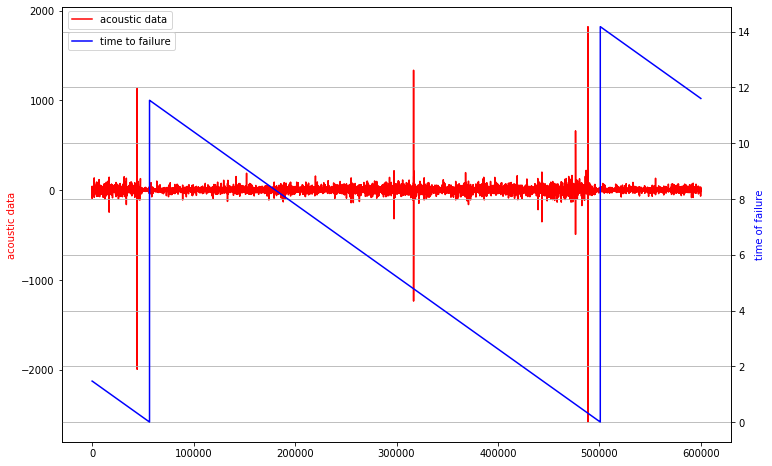

In [43]:
train_ad_sample_df= train['acoustic_data'].values[::100]
train_ttf_sample_df= train['time_to_failure'].values[::100]

# function on ploting based on both features
def plot_acc_tff_data(train_ad_sample_df,train_ttf_sample_df):
    fig, ax1= plt.subplots(figsize=(12,8))
    #plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data',color='r')
    plt.legend(['acoustic data'],loc=(0.01, 0.95))
    ax2= ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time of failure', color='b')
    plt.legend(['time to failure'], loc=(0.01,0.9))
    plt.grid(True)
    
plot_acc_tff_data(train_ad_sample_df,train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

# Step 4 Feature Engineering

In [50]:
def features(X):
    strain= []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    return pd.Series(strain)



In [61]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000,nrows=60000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [62]:
X_train.describe()

,0,1,2,3,4,5
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,4.518558,6.340648,-142.680000,62.001412,0.103444,-10.442575
std,0.193287,10.113793,305.450327,59.874440,0.504035,15.757687
min,3.798020,3.045099,-4621.000000,2.853541,-4.091826,-239.010000
25%,4.388698,4.154091,-138.000000,26.010094,-0.046554,-12.000000
50%,4.515837,5.216863,-101.500000,41.213078,0.083229,-9.000000
75%,4.655390,6.394032,-75.000000,75.057348,0.224922,-5.000000
max,5.010620,142.976883,-27.000000,446.956420,2.335182,-2.000000


# Implement catboost model

## Gradient Boosting

In [63]:
train_pool= Pool(X_train, y_train)
m= CatBoostRegressor(iterations=10000, loss_function='MAE',boosting_type='Ordered')
m.fit(X_train,y_train,silent= True)
m.best_score_

{'learn': {'MAE': 0.17491837773003838}}

# SVM

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.6034
{'C': 2, 'gamma': 0.1}
